<a href="https://colab.research.google.com/github/RobertoAlessandri/CNN_DOA/blob/main/FeatureExtraction_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
from pathlib import Path
from tqdm import tqdm # Progress bar
import sklearn
plt.style.use('seaborn')

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Extract audio data from a given list of filepaths assuming ordering wrt mics and sources
def extractAudiodata(filepaths, sample_len):
  sourcesDim = int(len(filepaths)/4)
  audioSignals = np.zeros([int(sample_len), 4, sourcesDim])
  sourceIDs = np.zeros([sourcesDim, 1])
  labels30 = np.zeros(sourceIDs.shape)
  labels10 = np.zeros(sourceIDs.shape)

  j = 0 # Indexing sources
  for i in tqdm(range(0, len(filepaths), 4)): # Indexing samples
    micsABCD = filepaths[i:i+4]

    # CHECKS ARE COMPUTATIONALLY DEMANDING
    # Checking if all microphones are present using the mic ID (A,B,C and D)
    #micIDs = [id.split('-')[-4] for id in micsABCD]
    #print(micIDs)
    #if micIDs != ['A', 'B', 'C', 'D']:
      #raise Exception("Filepaths are not ordered or aligned")

    # Checking if all the selected sample are from the same source using the source ID (from 0 to 5999 for the train dataset)
    #currentSourceIDs = [id.split('-')[-3] for id in micsABCD]
    #print(sourceIDs)
    #if len([True for id in currentSourceIDs if id == currentSourceIDs[0]]) != 4:
      #raise Exception("Filepaths are not ordered or aligned")
 
    for k in range(0, len(micsABCD)): # Indexing mics
      audioSignals[:, k, j] = librosa.load(micsABCD[k], sr=None)[0]

    fileid = micsABCD[0].split('.wav')[-2]
    sourceIDs[j] = fileid.split('-')[-3]
    labels30[j] = fileid.split('-')[-2]
    labels10[j] = fileid.split('-')[-1]
    j += 1


  return audioSignals, sourceIDs, labels30, labels10

In [ ]:
%cd /content/drive/MyDrive/Github/CNN_DOA/Dataset/TRAIN

/content/drive/.shortcut-targets-by-id/1-B6wbQJimyIAQNh3Ccp578yl6uudDF9j/CNN_DOA/Dataset/TRAIN


In [ ]:
import re 

def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [ ]:
# Get list of audio files in the current folder
audiofiles_train = [str(file) for file in Path().glob('SA*.wav')]
#audiofiles_train = sorted_nicely(audiofiles_train)

# Diminuisco un attimo la dimensione del dataset per gestirlo più velocemente
#audiofiles_train = audiofiles_train[:100]

sr = 16000
duration = 0.5

trainAudioMatrix, sourceIDs, labels30, labels10 = extractAudiodata(audiofiles_train, sr*duration) # At full load it took 14 mins with checks

100%|██████████| 6000/6000 [01:04<00:00, 92.74it/s] 


In [ ]:
print(trainAudioMatrix.shape)
print(sourceIDs.shape)
print(labels30.shape)
print(labels10.shape)

(8000, 4, 6000)
(6000, 1)
(6000, 1)
(6000, 1)


In [ ]:
# Checking correct labeling
for i in range(0, 10):
  print('{} with id {}: \n Label resolution 30° --> {}     Label resolution 10° --> {}'.format(audiofiles_train[i*4], int(sourceIDs[i]), int(labels30[i]), int(labels10[i])))

SA23000-A-5750-2-7.wav with id 5750: 
 Label resolution 30° --> 2     Label resolution 10° --> 7
SA23004-A-5751-7-21.wav with id 5751: 
 Label resolution 30° --> 7     Label resolution 10° --> 21
SA23008-A-5752-4-13.wav with id 5752: 
 Label resolution 30° --> 4     Label resolution 10° --> 13
SA23012-A-5753-4-12.wav with id 5753: 
 Label resolution 30° --> 4     Label resolution 10° --> 12
SA23016-A-5754-8-23.wav with id 5754: 
 Label resolution 30° --> 8     Label resolution 10° --> 23
SA23020-A-5755-1-4.wav with id 5755: 
 Label resolution 30° --> 1     Label resolution 10° --> 4
SA23024-A-5756-6-18.wav with id 5756: 
 Label resolution 30° --> 6     Label resolution 10° --> 18
SA23028-A-5757-7-21.wav with id 5757: 
 Label resolution 30° --> 7     Label resolution 10° --> 21
SA23032-A-5758-9-28.wav with id 5758: 
 Label resolution 30° --> 9     Label resolution 10° --> 28
SA23036-A-5759-8-23.wav with id 5759: 
 Label resolution 30° --> 8     Label resolution 10° --> 23


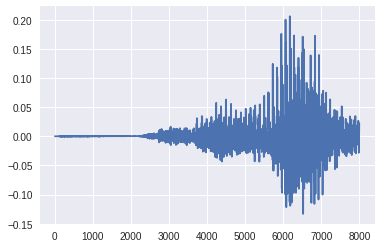

In [ ]:
ipd.display(ipd.Audio(trainAudioMatrix[:,0,0], rate=sr))
plt.plot(trainAudioMatrix[:,0,0])

## Flow:
1) microphone signals

2) STFT 

3) Active SI estimation

4) Whitening weighting

In [ ]:
def computeSI(X1, X2, X3, freqsMatrix, isOblique=False, X4=0,  d=0.04, rho=1.225, beta=1e6):
  #denominator = (freqsMatrix + np.finfo(np.float32).eps)*d*rho
  denominator = 1

  if isOblique:
    X0 = (X1 + X2 + X3) / 3
    V1 = (np.sqrt(2)*1j*(X2 - X1)) / denominator
    V2 = (np.sqrt(2)*1j*(X2 - X3)) / denominator
  else:
    X0 = (X1 + X2 + X3 + X4) / 4
    V1 = (1j*(X3 - X1)) / denominator
    V2 = (1j*(X4 - X2)) / denominator

  W = (np.abs(X0)**2 + beta*(np.abs(V1)**2 + np.abs(V2)**2) )**0.5

  I1 = (np.real(X0*np.conj(V1)) / W).T
  I2 = (np.real(X0*np.conj(V2)) / W).T

  matrix = np.zeros([I1.shape[0], I1.shape[1], 2])
  matrix[:, :, 0] = I1
  matrix[:, :, 1] = I2

  #print('{} --> {}'.format(matrix[:,0,0], matrix[:,-1,0]))
  return matrix

In [ ]:
def featureExtractor2(micSignals, d=0.04, rho=1.225, NFFT=1024, sr=16000, beta=1e6):
  frame_length = NFFT
  hop_length = int(frame_length/2) 
  num_samples = micSignals[:,0].shape[0]
  num_frames = int(1 + np.floor((num_samples - frame_length) / hop_length))
  freqs = librosa.fft_frequencies(sr=sr, n_fft=NFFT) #/ (sr/2) * np.pi # Frequency, normalized, angular?
  #freqs = np.flip(freqs)
  freqs = np.reshape(freqs, (len(freqs),1))
  freqsMatrix = np.tile(freqs, (1, num_frames))
  #print(freqsMatrix)

  gamma = np.zeros([num_frames, int(NFFT/2 - 1), 10])
  #print(gamma.shape)

  P1 = librosa.stft(micSignals[:,0], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P2 = librosa.stft(micSignals[:,1], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P3 = librosa.stft(micSignals[:,2], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P4 = librosa.stft(micSignals[:,3], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)

  # Principal directions
  gamma[:,:,0:2] = computeSI(P1, P2, P3, freqsMatrix, isOblique=False, X4=P4, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2] # Using : last index is excluded
  
  # Subarrays
  gamma[:,:,2:4]  = computeSI(P4, P1, P2, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,4:6]  = computeSI(P1, P2, P3, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,6:8]  = computeSI(P2, P3, P4, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,8:10] = computeSI(P3, P4, P1, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]

  return gamma

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


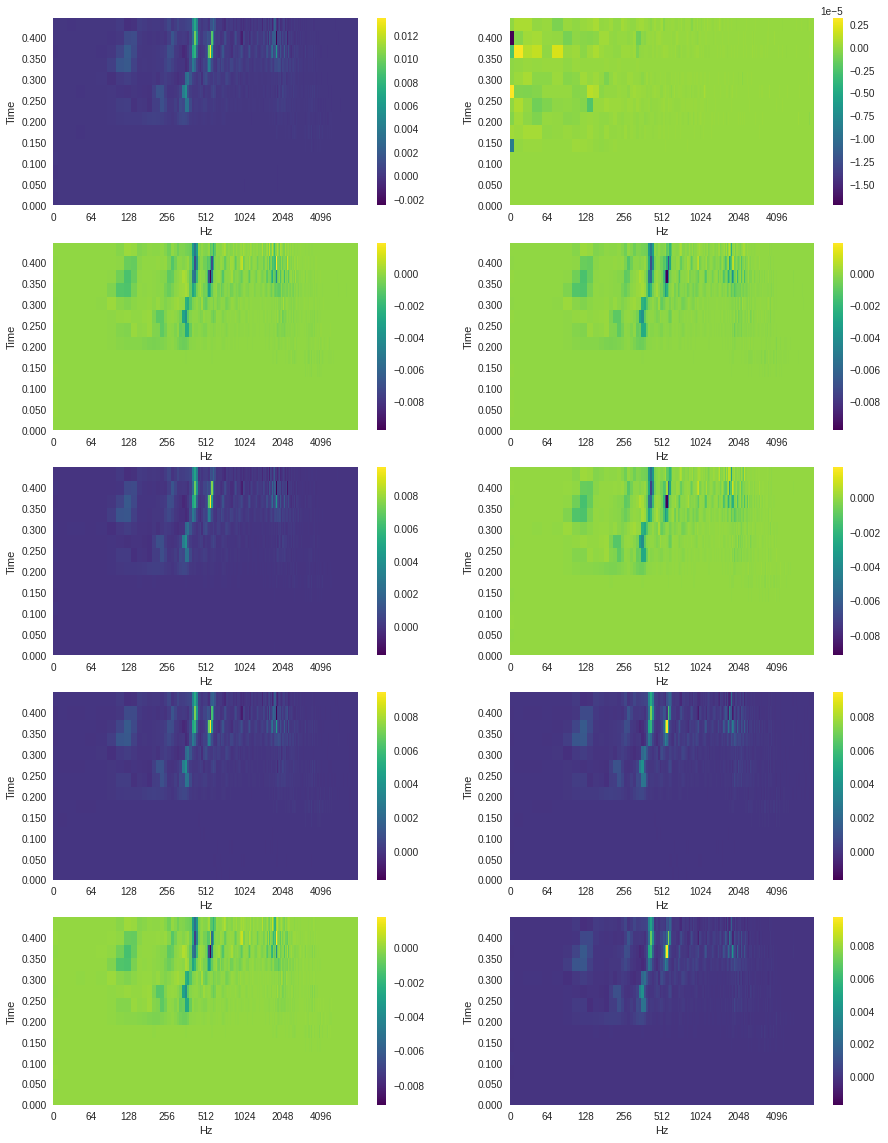

In [ ]:
#test(*(trainAudioMatrix[:,:,0].T))
gamma = featureExtractor2(trainAudioMatrix[:,:,0])
#print(np,abs(X[-1,:]))
plt.figure(figsize=(15, 20))
for i in range(0, 10):
  plt.subplot(5, 2, i+1)
  librosa.display.specshow(gamma[:,:,i], sr=sr, x_axis='log', y_axis='time', cmap='viridis')
  plt.colorbar();

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


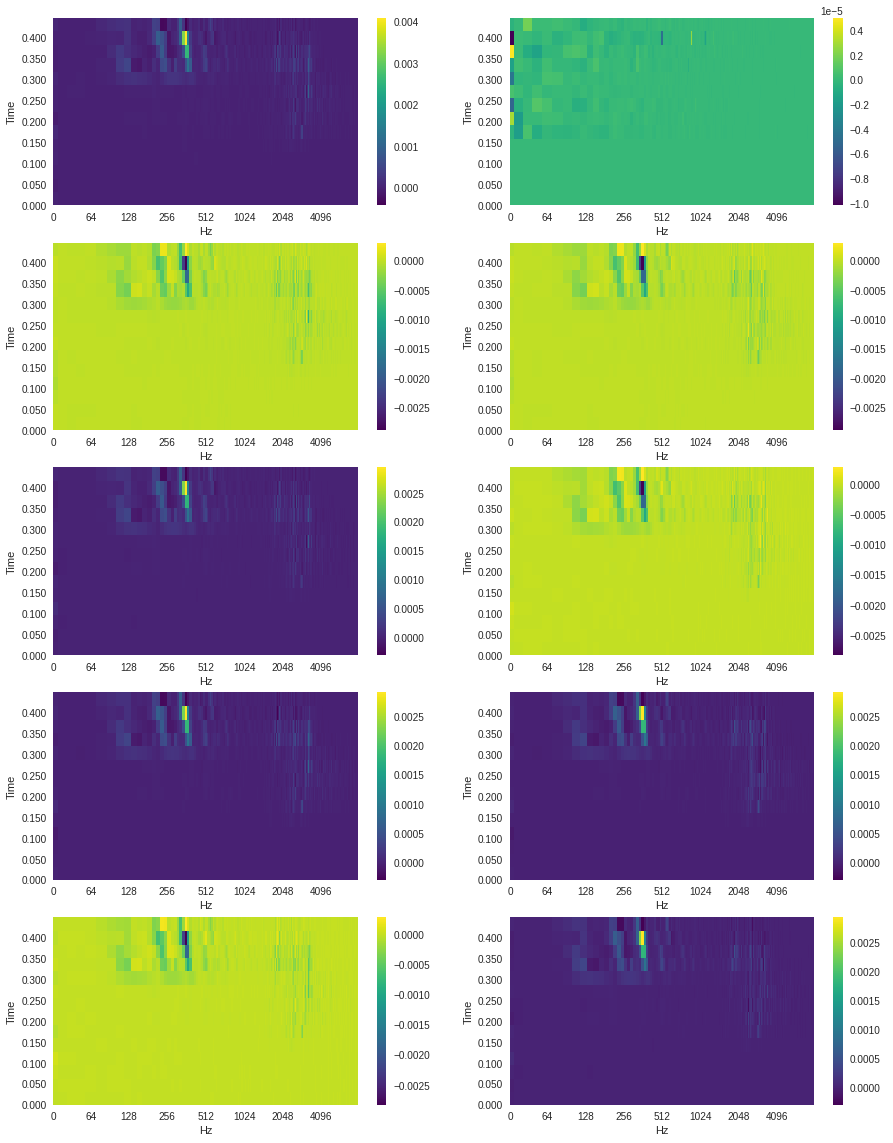

In [ ]:
#test(*(trainAudioMatrix[:,:,0].T))
gamma = featureExtractor2(trainAudioMatrix[:,:,100])
#print(np,abs(X[-1,:]))
plt.figure(figsize=(15, 20))
for i in range(0, 10):
  plt.subplot(5, 2, i+1)
  librosa.display.specshow(gamma[:,:,i], sr=sr, x_axis='log', y_axis='time', cmap='viridis')
  plt.colorbar();

In [ ]:
trainAudioMatrix.shape
datapointsNum = trainAudioMatrix.shape[-1]
Gamma_container = np.zeros([datapointsNum, 14, 511, 10])
print(Gamma_container.shape)

for i in tqdm(range(0, datapointsNum)):
  Gamma_container[i,:,:,:] = featureExtractor2(trainAudioMatrix[:,:,i])

(6000, 14, 511, 10)


  0%|          | 0/6000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)
100%|██████████| 6000/6000 [00:50<00:00, 118.98it/s]


In [ ]:
# Normalization
Gamma_container = (Gamma_container - np.min(Gamma_container)) / np.max(Gamma_container)

In [ ]:
print(np.min(Gamma_container))
print(np.max(Gamma_container))

0.0
1.0


According to the theory on Sound Intensity (SI), only the real part (active intensity vector) contains the location information of a sound source.

In [ ]:
## TEST TENSORFLOW  
from tensorflow.keras import datasets, layers, models

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
#print("Train images:")
print("Type: ", type(train_images.shape))
print("Shape: ", train_images.shape)

#print("Train Labels")
#print("Type: ", type(train_labels.shape))
#print("Shape: ", train_labels.shape)
#print(train_labels[0:3])

Type:  <class 'tuple'>
Shape:  (50000, 32, 32, 3)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (1, 1), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 64)          4160      
                                                                 
 flatten_1 (Flatten)         (None, 2304)             

In [ ]:
#opt = keras.optimizers.SGD(lr=0.01)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=30, validation_split=0.2)

Epoch 1/30
1250/1250 [==============================] - 10s 7ms/step - loss: 1.3785 - accuracy: 0.5613 - val_loss: 1.3271 - val_accuracy: 0.5462
Epoch 2/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.3258 - accuracy: 0.5709 - val_loss: 1.5016 - val_accuracy: 0.4793
Epoch 3/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.2889 - accuracy: 0.5763 - val_loss: 1.3399 - val_accuracy: 0.5351
Epoch 4/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.2587 - accuracy: 0.5883 - val_loss: 1.2322 - val_accuracy: 0.5963
Epoch 5/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.2515 - accuracy: 0.5929 - val_loss: 1.3356 - val_accuracy: 0.5897
Epoch 6/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.2447 - accuracy: 0.5936 - val_loss: 1.2761 - val_accuracy: 0.5859
Epoch 7/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.2326 - accuracy: 0.6047 - val_loss: 1.3440 - val_accuracy

## Network Architecture

- Each convolutional layer uses 64 convolution kernels with the size of 3*3, to learn local correlations between local T-F regions.
- BN layer is used after each convolutional layer to improve the stability of the network and speed up the convergence of the network.
- The activation function of convolutional layers and fully connected layers is ReLU.
- Between the convolutional layer and the fully connected layer and after each fully connected layer, a droput procedure with rate 0.5 is used to avoid overfitting.
- size and number of convolutional kernels = . ? 
number of nodes in the fully connected layers = 512?.
- input = SI features
- The fully connected layer combines all the features extracted by the convolution layer to reduce the input 2D feature matrix to a 1D feature vector to facilitate the output layer for classification processing.
- SoftMax function is used to perform clssification
- The final source DOA is estimated by maximizing the posterior prbability 
- In the CNN training, the cross-entropy functon is used as the loss function
- We employ the Adam as the optimizer
- Initial learning rate is set to be 10^-3
- Maximum number of epochs = 100
- Early stopping with a patience of 10 epochs measured on the validation set is als used to prevent overfitting.



In [ ]:
filters = 64
kernel_size = (3,3)
strides = (1,1)
input_shape = (14, 511, 10)
#input_shape = (32, 32, 3)
rate = 0.5
K = 36 # Then we will try also with K = 36 or 12

model = keras.Sequential ([
  #keras.layers.Input(shape=input_shape),
  # input layer (14 * 511 * 10) (convolutional layers + batch normalization (BN) w ReLU)
  #keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, input_shape = input_shape, center=False, scale=False, beta_initializer="zeros", gamma_initializer="ones", moving_mean_initializer="zeros", moving_variance_initializer="ones", beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None, name = 'bn1'),                     
  keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', input_shape=input_shape, padding='valid', data_format = 'channels_last', use_bias = True, name='conv1'),
  keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=False, scale=False, beta_initializer="zeros", gamma_initializer="ones", moving_mean_initializer="zeros", moving_variance_initializer="ones", beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None, name = 'bn1'),
  # 2nd convolutional layers + batch normalization (BN) w ReLU
  keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', padding='valid', data_format = 'channels_last', use_bias = True, name='conv2'),
  keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=False, scale=False, beta_initializer="zeros", gamma_initializer="ones", moving_mean_initializer="zeros", moving_variance_initializer="ones", beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None, name = 'bn2'),
  # dropout procedure with rate 0.5
  tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, name = 'dn1'),
  # 1st fully connected layer w ReLU & dropout procedure with rate 0.5
  keras.layers.Flatten(name='flatten'),
  tf.keras.layers.Dense(512, activation = 'relu', name = 'fc1'),
  tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, name = 'dn2'),
  # 2nd fully connected layer w ReLU & dropout procedure with rate 0.5
  tf.keras.layers.Dense(512, activation = 'relu', name = 'fc2'),
  tf.keras.layers.Dropout(rate, noise_shape=None, seed=None, name = 'dn3'),
  # SoftMax
  #tf.keras.layers.Softmax()
  #tf.keras.layers.Dense(K, activation = 'softmax', name = 'output'),
  tf.keras.layers.Dense(K),
])

# keras.layers.Flatten(name='flatten'),?


In [ ]:
# Let's show the architecture of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 12, 509, 64)       5824      
                                                                 
 bn1 (BatchNormalization)    (None, 12, 509, 64)       128       
                                                                 
 conv2 (Conv2D)              (None, 10, 507, 64)       36928     
                                                                 
 bn2 (BatchNormalization)    (None, 10, 507, 64)       128       
                                                                 
 dn1 (Dropout)               (None, 10, 507, 64)       0         
                                                                 
 flatten (Flatten)           (None, 324480)            0         
                                                                 
 fc1 (Dense)                 (None, 512)               1

## Compiling the Model

label-->one hot
validation

In [ ]:
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', # sparse?
              metrics='accuracy'
)

# run_eagerly

## Training the Model

In [ ]:
oneHotLabels30 = np.zeros([labels30.shape[0], K])
oneHotLabels30.shape

(6000, 36)

In [ ]:
labels30.shape[0]

6000

In [ ]:
oneHot = np.zeros([K])
oneHot.shape

(36,)

In [ ]:
for i in range(0, labels30.shape[0]):
  oneHot = np.zeros([K])
  oneHot[int(labels30[i])] = int(1)
  oneHotLabels30[i, :] = oneHot

In [ ]:
for i in range(0, 5):
  print('class {} --> {}'.format(int(labels30[i]), oneHotLabels30[i][int(labels30[i])]))

class 8 --> 1.0
class 6 --> 1.0
class 11 --> 1.0
class 2 --> 1.0
class 11 --> 1.0


In [ ]:
print(oneHotLabels30.shape)
print(labels30.shape)

(6000, 36)
(6000, 1)


In [ ]:
#tf.config.run_functions_eagerly(True)

In [ ]:
model.fit(Gamma_container, labels30, validation_split = 0.2, epochs=100)

Epoch 1/100
150/150 [==============================] - 24s 79ms/step - loss: 12.6926 - accuracy: 0.1204 - val_loss: 11.9758 - val_accuracy: 0.1500
Epoch 2/100
150/150 [==============================] - 10s 66ms/step - loss: 12.7684 - accuracy: 0.1396 - val_loss: 11.9758 - val_accuracy: 0.1500
Epoch 3/100
150/150 [==============================] - 10s 66ms/step - loss: 13.1983 - accuracy: 0.1504 - val_loss: 13.7004 - val_accuracy: 0.1500
Epoch 4/100
150/150 [==============================] - 10s 66ms/step - loss: 13.6190 - accuracy: 0.1498 - val_loss: 13.7004 - val_accuracy: 0.1500
Epoch 5/100
150/150 [==============================] - 10s 67ms/step - loss: 13.7766 - accuracy: 0.1496 - val_loss: 13.7004 - val_accuracy: 0.1500
Epoch 6/100
150/150 [==============================] - 10s 67ms/step - loss: 13.8787 - accuracy: 0.1498 - val_loss: 13.7004 - val_accuracy: 0.1500
Epoch 7/100
150/150 [==============================] - 10s 66ms/step - loss: 13.8173 - accuracy: 0.1498 - val_loss: 13

In [ ]:
%cd /content/drive/MyDrive/Github/CNN_DOA/model/

In [ ]:
## Saving the model
model.save('modelRes30')

## Evaluating Accuracy

In [ ]:
%cd /content/drive/MyDrive/Github/CNN_DOA/model

In [ ]:
## If I want to load the model 
model = keras.models.load_model('modelRes30')

In [ ]:
%cd /content/drive/MyDrive/Github/CNN_DOA/Dataset/TEST/RES30

In [ ]:
# Get list of audio files in the current folder
audiofiles_test = [str(file) for file in Path().glob('SA*.wav')]
#print((audiofiles_test))

# Diminuisco un attimo la dimensione del dataset per gestirlo più velocemente
#audiofiles_test = audiofiles_test[:100]

sr = 16000
duration = 0.5

testAudioMatrix, testSourceIDs, testLabels30, testLabels10 = extractAudiodata(audiofiles_test, sr*duration) # Full load took 14 mins

In [ ]:
# Checking correct labeling
for i in range(0, 10):
  print('{} with id {}: \n Label resolution 30° --> {}     Label resolution 10° --> {}'.format(audiofiles_test[i*4], int(testSourceIDs[i]), int(testLabels30[i]), int(testLabels10[i])))

In [ ]:
ipd.display(ipd.Audio(testAudioMatrix[:,0,100], rate=sr))
plt.plot(testAudioMatrix[:,0,0])

In [ ]:
testAudioMatrix.shape
datapointsNum = testAudioMatrix.shape[-1]
Gamma_container = np.zeros([datapointsNum, 14, 511, 10])
print(Gamma_container.shape)

for i in tqdm(range(0, datapointsNum)):
  Gamma_container[i,:,:,:] = featureExtractor2(testAudioMatrix[:,:,i])

In [ ]:
type(Gamma_container)

In [ ]:
# Check how model performs on test dataset
test_loss, test_acc = model.evaluate(Gamma_container,  testLabels30, verbose=2)

print('\nTest accuracy:', test_acc)

## Predictions

In [ ]:
# Predictions over test set
predictions = model.predict(test_audio)

# Show result
audio_idx = 0 # Idx of image
print('Model output:',predictions[audio_idx])
print('Predicted label:', np.argmax(predictions[audio_idx]))
print('Ground truth label:',test_labels[audio_idx])

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
num_rows = 5
num_cols = 3
num_audio = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_audio):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_audio)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()